In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()
%matplotlib inline
from matplotlib.pyplot import rcParams
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras import layers
np.random.seed(0)

                      Formatted Date        Summary Precip Type  \
0      2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain   
1      2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain   
2      2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain   
3      2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain   
4      2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain   
...                              ...            ...         ...   
96448  2016-09-09 19:00:00.000 +0200  Partly Cloudy        rain   
96449  2016-09-09 20:00:00.000 +0200  Partly Cloudy        rain   
96450  2016-09-09 21:00:00.000 +0200  Partly Cloudy        rain   
96451  2016-09-09 22:00:00.000 +0200  Partly Cloudy        rain   
96452  2016-09-09 23:00:00.000 +0200  Partly Cloudy        rain   

       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0             9.472222                  7.388889      0.89            14.1197   
1             9.355556           

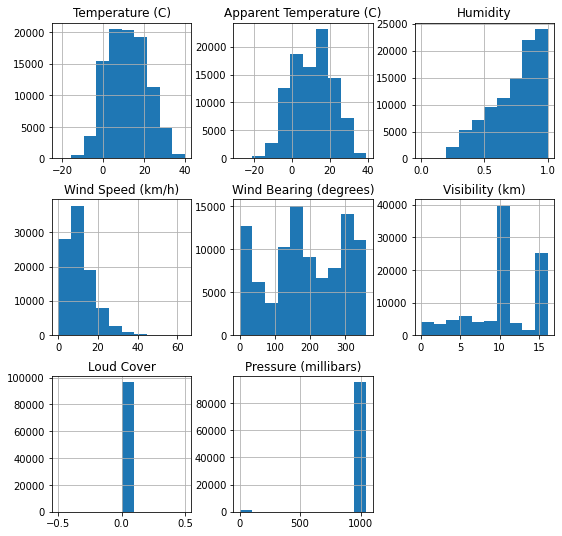

In [2]:
# Exercício 10.1 - Nº 01
weatherHistoryOriginal = pd.read_csv('../input/szeged-weather/weatherHistory.csv')
print(weatherHistoryOriginal)

valoresFaltantes = []
print("\nValores nulos: ")
for col in weatherHistoryOriginal.columns:
    if pd.isnull(weatherHistoryOriginal[col]).sum() != 0:
        print("- {}: {} valores nulos".format(col, 
                                                pd.isnull(weatherHistoryOriginal[col]).sum()))
        valoresFaltantes.append(col)
        
describe = weatherHistoryOriginal.describe()

rcParams['figure.figsize'] = 9, 9
weatherHistoryOriginal.hist()

valoresErradosPressure = weatherHistoryOriginal.loc[weatherHistoryOriginal[
    'Pressure (millibars)'] == 0]['Pressure (millibars)'].count()
print("\nA quantidade de valores errados em 'Pressure (millibars)' é ", valoresErradosPressure)

In [3]:
# Exercício 10.1 - Nº 02
features_categoricas = []
features_numericas = []
for col in weatherHistoryOriginal.columns:
    if weatherHistoryOriginal[col].dtype == object:
        features_categoricas.append(col)
    else:
        features_numericas.append(col)

print("\nAs features categóricas são: ")
for col in features_categoricas:
    print("- ", col)

print("\nAs features numéricas são: ")
for col in features_numericas:
    print("- ", col)

print('\n')
for col in features_categoricas:
    print(col,'\n', weatherHistoryOriginal[col].value_counts() ,'\n\n')


As features categóricas são: 
-  Formatted Date
-  Summary
-  Precip Type
-  Daily Summary

As features numéricas são: 
-  Temperature (C)
-  Apparent Temperature (C)
-  Humidity
-  Wind Speed (km/h)
-  Wind Bearing (degrees)
-  Visibility (km)
-  Loud Cover
-  Pressure (millibars)


Formatted Date 
 2010-08-02 00:00:00.000 +0200    2
2010-08-02 12:00:00.000 +0200    2
2010-08-02 03:00:00.000 +0200    2
2010-08-02 04:00:00.000 +0200    2
2010-08-02 05:00:00.000 +0200    2
                                ..
2009-03-09 22:00:00.000 +0100    1
2009-03-09 21:00:00.000 +0100    1
2009-03-09 20:00:00.000 +0100    1
2009-03-09 19:00:00.000 +0100    1
2016-09-09 23:00:00.000 +0200    1
Name: Formatted Date, Length: 96429, dtype: int64 


Summary 
 Partly Cloudy                          31733
Mostly Cloudy                          28094
Overcast                               16597
Clear                                  10890
Foggy                                   7148
Breezy and Overcast     

In [4]:
# Exercício 10.2 - Nº 01
# Retirando o fuso horário da data
weatherHistory = weatherHistoryOriginal.copy()
weatherHistory["Formatted Date"] = weatherHistory["Formatted Date"].str.split("+", expand = True)[0]

# Tranformando a coluna 'Formatted Date' em datetime
weatherHistory["Formatted Date"] = pd.to_datetime(weatherHistory["Formatted Date"])

# Retirando informações de hora, dia, mês e ano de cada valor de data
weatherHistory["Hour"] = weatherHistory["Formatted Date"].dt.hour
weatherHistory["Day"] = weatherHistory["Formatted Date"].dt.day
weatherHistory["Month"] = weatherHistory["Formatted Date"].dt.month
weatherHistory["Year"] = weatherHistory["Formatted Date"].dt.year

weatherHistory = weatherHistory.drop(["Formatted Date"], axis = 1)

print(weatherHistory.head())

         Summary Precip Type  Temperature (C)  Apparent Temperature (C)  \
0  Partly Cloudy        rain         9.472222                  7.388889   
1  Partly Cloudy        rain         9.355556                  7.227778   
2  Mostly Cloudy        rain         9.377778                  9.377778   
3  Partly Cloudy        rain         8.288889                  5.944444   
4  Mostly Cloudy        rain         8.755556                  6.977778   

   Humidity  Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
0      0.89            14.1197                   251.0          15.8263   
1      0.86            14.2646                   259.0          15.8263   
2      0.89             3.9284                   204.0          14.9569   
3      0.83            14.1036                   269.0          15.8263   
4      0.83            11.0446                   259.0          15.8263   

   Loud Cover  Pressure (millibars)                      Daily Summary  Hour  \
0         0.0     

In [5]:
# Exercício 10.2 - Nº 02
weatherHistory = weatherHistory.drop(["Loud Cover"], axis = 1)
weatherHistory.drop(weatherHistory.loc[weatherHistory["Summary"].isin(["Breezy and Dry","Windy and Dry","Dangerously Windy and Partly Cloudy"])].index, inplace=True)
features_categoricas = []
features_numericas = []
for col in weatherHistory.columns:
    if weatherHistory[col].dtype == object:
        features_categoricas.append(col)
    else:
        features_numericas.append(col)

features_categoricas.remove('Daily Summary')

# Pré-processamento de dados numéricos
numerical_transformer = SimpleImputer(strategy = 'mean', missing_values = 0)

# Pré-processamento de dados categóricos
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder())
    ])

# Pré-processamento de pacotes para dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, features_numericas),
    ('cat', categorical_transformer, features_categoricas)])

In [6]:
# Exercício 10.2 - Nº 03
y = weatherHistory["Daily Summary"]
X = weatherHistory.drop(["Daily Summary"], axis = 1)
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0, 
                                                  test_size = 0.3, stratify = y)

train_X = preprocessor.fit_transform(train_X)
val_X = preprocessor.transform(val_X)

label = LabelEncoder()
train_y = label.fit_transform(train_y)
val_y = label.transform(val_y)

In [7]:
# Exercício 10.3 - Nº 01
tamanhoEntrada = X.shape[1]
tamanhoSaida = y.unique().shape[0]

model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape = [tamanhoEntrada]),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(tamanhoSaida, activation='softmax'),
])

train_y = keras.utils.to_categorical(train_y)
val_y = keras.utils.to_categorical(val_y)

2022-09-12 01:53:49.705680: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
# Exercício 10.3 - Nº 02
model.compile(optimizer = "adam",
            loss = "categorical_crossentropy",
            metrics = "categorical_accuracy")

2022-09-12 01:53:50.109177: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
23/23 [==============================] - 3s 70ms/step - loss: 5.3408 - categorical_accuracy: 0.0668 - val_loss: 91.1331 - val_categorical_accuracy: 2.4192e-04
Epoch 2/100
23/23 [==============================] - 1s 60ms/step - loss: 4.3501 - categorical_accuracy: 0.1744 - val_loss: 106.8301 - val_categorical_accuracy: 0.2083
Epoch 3/100
23/23 [==============================] - 1s 56ms/step - loss: 3.8072 - categorical_accuracy: 0.2132 - val_loss: 74.9269 - val_categorical_accuracy: 0.0037
Epoch 4/100
23/23 [==============================] - 1s 58ms/step - loss: 3.5090 - categorical_accuracy: 0.2267 - val_loss: 95.3154 - val_categorical_accuracy: 0.0019
Epoch 5/100
23/23 [==============================] - 1s 58ms/step - loss: 3.3281 - categorical_accuracy: 0.2364 - val_loss: 119.3172 - val_categorical_accuracy: 0.0272
Epoch 6/100
23/23 [==============================] - 1s 53ms/step - loss: 3.1998 - categorical_accuracy: 0.2442 - val_loss: 170.7817 - val_categorical_accuracy

<AxesSubplot:title={'center':'Resultados da acurácia'}>

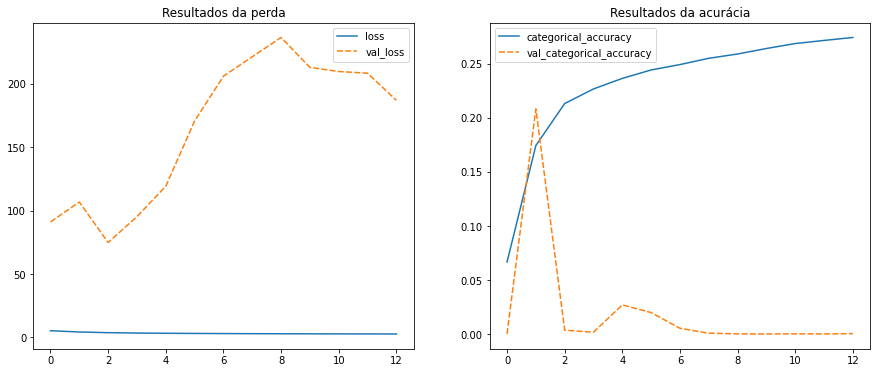

In [9]:
# Exercício 10.3 - Nº 03
early = keras.callbacks.EarlyStopping(patience = 10, min_delta = 000.1, restore_best_weights = True)

history = model.fit(
    train_X, train_y, 
    validation_data = (val_X, val_y), 
    batch_size = 3000, 
    epochs = 100, 
    callbacks = [early])

history = pd.DataFrame(history.history)

fig, eixos = plt.subplots(1, 2, figsize = (15,6))

eixos[0].set_title("Resultados da perda")
sns.lineplot(data = history.loc[:,["loss", "val_loss"]], ax = eixos[0])

eixos[1].set_title("Resultados da acurácia")
sns.lineplot(data = history.loc[:,["categorical_accuracy", "val_categorical_accuracy"]], ax = eixos[1])